# Stereo Disparity:  Semi Global Matching Algorithm & Normalised Cross Correlation

## Libraries

In [1]:
# Import libraries
import os
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np                          
import cv2                  

## Image Data Preprocess

In [2]:
# Load image
ROOTPATH = "./Dataset"

class ImagePath():
    
    def __init__(self, disparity_img_paths):
        self.disparity_img_path = disparity_img_paths
        self.left_img_path = disparity_img_paths.replace("-disparity.png", "-left.jpg")
        self.right_img_path = disparity_img_paths.replace("-disparity.png", "-right.jpg")
        
    def __str__(self) -> str:
        return self.disparity_img_path.replace("-disparity.png", "")
    
    def __eq__(self, other: object) -> bool:
        return str(self) == str(other)


image_name = "2018-07-09-16-11-56_2018-07-09-16-13-38-366"
sample_img = ImagePath(os.path.join(ROOTPATH, image_name + "-disparity.png"))    

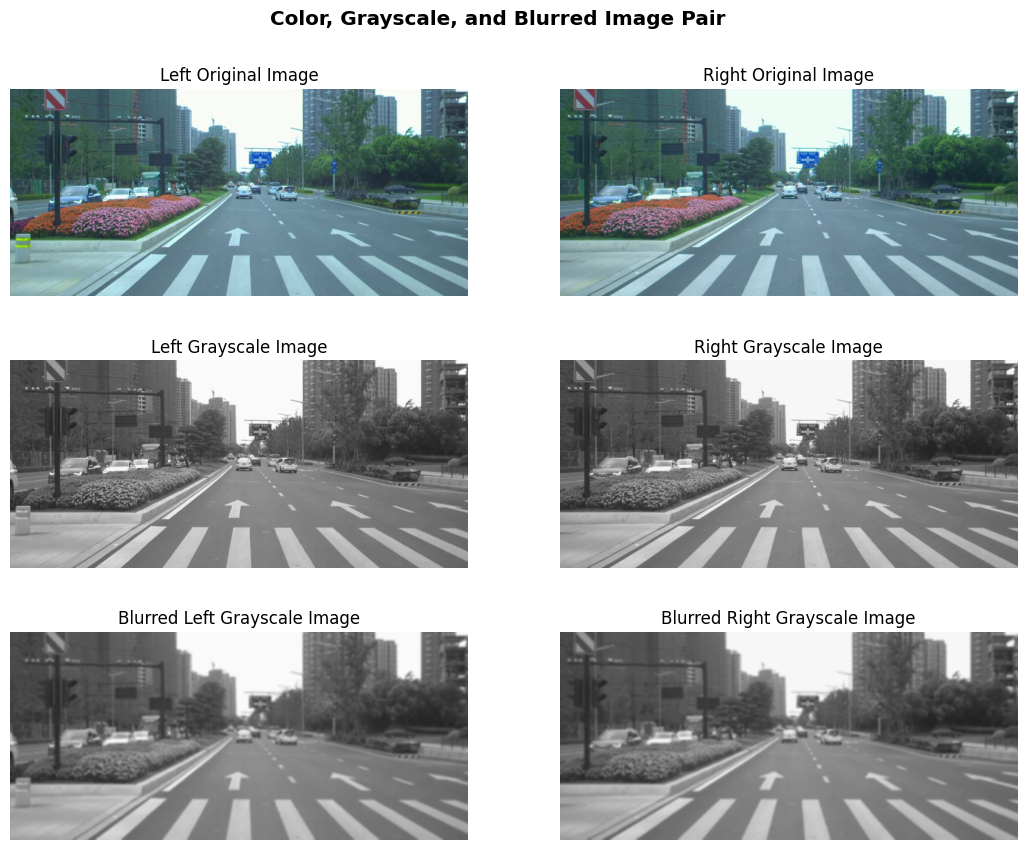

In [3]:
# Preprocess image
img_L = cv2.imread(sample_img.left_img_path, cv2.IMREAD_COLOR)
img_R = cv2.imread(sample_img.right_img_path, cv2.IMREAD_COLOR)

# Load ground truth image 
img_tru = cv2.imread(sample_img.disparity_img_path, -1)

# Convert image to gray-scale
img_L_gray = cv2.cvtColor(img_L, cv2.COLOR_BGR2GRAY)
img_R_gray = cv2.cvtColor(img_R, cv2.COLOR_BGR2GRAY)

# Blur image to reduce noises
img_L_gray_blur = cv2.GaussianBlur(img_L_gray, ksize=[7,7], sigmaX=2, sigmaY=2)
img_R_gray_blur = cv2.GaussianBlur(img_R_gray, ksize=[7,7], sigmaX=2, sigmaY=2)

f, axis = plt.subplots(3,2, figsize=(13,10))
f.suptitle("Color, Grayscale, and Blurred Image Pair", fontsize="x-large", fontweight="bold", y=0.95)
axis[0, 0].imshow(cv2.cvtColor(img_L, cv2.COLOR_BGR2RGB))
axis[0, 0].set_title("Left Original Image")
axis[0, 0].set_axis_off()

axis[0, 1].imshow(cv2.cvtColor(img_R, cv2.COLOR_BGR2RGB))
axis[0, 1].set_title("Right Original Image")
axis[0, 1].set_axis_off()

axis[1, 0].imshow(cv2.cvtColor(img_L_gray, cv2.COLOR_BGR2RGB))
axis[1, 0].set_title("Left Grayscale Image")
axis[1, 0].set_axis_off()

axis[1, 1].imshow(cv2.cvtColor(img_R_gray, cv2.COLOR_BGR2RGB))
axis[1, 1].set_title("Right Grayscale Image")
axis[1, 1].set_axis_off()

axis[2, 0].imshow(cv2.cvtColor(img_L_gray_blur, cv2.COLOR_BGR2RGB))
axis[2, 0].set_title("Blurred Left Grayscale Image")
axis[2, 0].set_axis_off()

axis[2, 1].imshow(cv2.cvtColor(img_R_gray_blur, cv2.COLOR_BGR2RGB))
axis[2, 1].set_title("Blurred Right Grayscale Image")
axis[2, 1].set_axis_off()


## Normalised Cross Correlation

### Standard Version

In [4]:
class MatchCost():
    def __init__(self, img_L, img_R):
        self.img_L = np.array(img_L, dtype=np.float64)
        self.img_R = np.array(img_R, dtype=np.float64)
    
    def compute(self, disparity_level=5, window_size=3):
        """Compute the matching cost usinng normalised cross correlation method

        Args:
            disparity_level (int, optional):
                The maximum disparity to search. Defaults to 5.
            window_size (int, optional):
                The width of the square matching window. The value should be an odd integer. Defaults to 3.

        Returns:
            disparity_map (float, numpy.ndarray, shape(H, W)):
                A matrix of disparity values of each pixel in the image
            cost_map (float, numpy.ndarray, shape(H, W, disparity_level+1)):
                The cost value for each position (height, width, disparity)
        """
        
        # start timing
        start = time.time()
        
        # Initialise parameters
        H, W = self.img_L.shape
        disparity_level += 1
        # the radius of the window
        half_window_size = window_size // 2        
        cost_map = np.zeros((H, W, disparity_level), dtype=np.float64)
        
        # loop through image
        for h in tqdm(range(half_window_size, H-half_window_size, 1)):
            
            for w in range(half_window_size+ disparity_level, W-half_window_size, 1):
                
                # loop through disparity
                for d in range(disparity_level):
                    
                    # cost_map[h, w, d] = -self.normalise_cross_correlate(p_L=(h, w), p_R=(h, w+disparity_level-d), window_size=window_size)
                     if w-half_window_size-d >= 0:
                         cost_map[h,w,d] = -self.normalise_cross_correlate(p_L=(h, w), p_R=(h, w - d), window_size=window_size)
                     else:
                         # if the matching position in img_R is out of bound, match the left position with the most left pixel in img_R
                         cost_map[h,w,d] = -self.normalise_cross_correlate(p_L=(h, w), p_R=(h, 0), window_size=window_size)
        
        self.cost_map = cost_map
        self.disparity_map = np.argmin(cost_map, axis=2)
        
        # Recoard function runtime
        end = time.time()
        self.runtime = end-start
        
        return self.disparity_map, self.cost_map
    
    
    def normalise_cross_correlate(self, p_L, p_R, window_size):
        """Calculate the normalised cross correlation of the two windows
           in img_L and img_R at the position of p_L and p_R

        Args:
            p_L ((int, int)):
                The cooridinate of the window center at img_L. 
                The first element is the height, the second element is the widths
            p_R ((int, int)):
                the cooridinate of the window center at img_R. 
                The first element is the height, the second element is the widths
            window_size (int, odd number):
                The dimension of the square window.  The value should be an odd integer

        Returns:
            normalised_cross_correlation (float):
                The normalised cross correlation of the two windows
                in img_L and img_R at the position of p_L and p_R.  The value is a float >= 0
        """
        
        h_L, w_L = p_L
        h_R, w_R = p_R
        
        half_window_size = window_size // 2
        
        matrix_L = self.img_L[h_L - half_window_size : h_L + half_window_size + 1, w_L - half_window_size : w_L + half_window_size + 1]
        matrix_R = self.img_R[h_R - half_window_size : h_R + half_window_size + 1, w_R - half_window_size : w_R + half_window_size + 1]
        
        # Shift the value so that the mean of the matrix is 0
        matrix_L = matrix_L - np.mean(matrix_L, dtype=np.float64)
        matrix_R = matrix_R - np.mean(matrix_R, dtype=np.float64)

        # Compute the scaling factor of the matrix
        norm_L = np.linalg.norm(matrix_L)
        norm_R = np.linalg.norm(matrix_R)
        
        # return normalised cross correlation value, if the norm of either matrix is 0 and two matrices are not identical, return 0
        # if the norm of either matrix is 0 but the two matrices are identical, return 1
        cc = np.sum((matrix_L * matrix_R), dtype=np.float64)
        if norm_L !=0 and norm_R !=0:
            cc = np.sum((matrix_L * matrix_R))
            ncc = cc / (norm_L * norm_R)
        elif np.array_equal(matrix_L, matrix_R):
            ncc = 1
        else:
            ncc = 0
        
        return ncc

### Cache Version

In [5]:
class MatchCost_Cache():
    
    def __init__(self, img_L, img_R):
        self.img_L = np.array(img_L, dtype=np.float64)
        self.img_R = np.array(img_R, dtype=np.float64)
    
    def compute(self, disparity_level=5, window_size=3):
        """Compute the matching cost usinng normalised cross correlation method

        Args:
            disparity_level (int, optional):
                The maximum disparity to search. Defaults to 5.
            window_size (int, optional):
                The width of the square matching window. The value should be an odd integer. Defaults to 3.

        Returns:
            disparity_map (float, numpy.ndarray, shape(H, W)):
                A matrix of disparity values of each pixel in the image
            cost_map (float, numpy.ndarray, shape(H, W, disparity_level+1)):
                The cost value for each position (height, width, disparity)
        """
        
        # start timing
        start = time.time()        

        # Set up parameters
        H, W = self.img_L.shape
        disparity_level += 1
        half_window_size = window_size // 2        
        
        # Initialise cost map 
        cost_map = np.zeros((H, W, disparity_level), dtype=np.float64)
    
        # Caches
        img_L_mean_cache, img_L_scalar_cache = self.matrix_cache(self.img_L, window_size)
        
        img_R_shift = np.copy(self.img_R)
        img_R_mean_cache, img_R_scalar_cache = self.matrix_cache(img_R_shift, window_size)
        
        # Loop through disparity    
        for d in tqdm(range(disparity_level)):
            
            # cross correlation cache
            cross_corr_cache = self.img_L * img_R_shift
            
            for h in range(half_window_size, H-half_window_size):
                
                for w in range(half_window_size+d, W-half_window_size):
                    
                    window_L = self.img_L[h-half_window_size:h+half_window_size+1, w-half_window_size:w+half_window_size+1]
                    window_R = img_R_shift[h-half_window_size:h+half_window_size+1, w-half_window_size:w+half_window_size+1]
                    
                    cross_corr = cross_corr_cache[h-half_window_size:h+half_window_size+1, w-half_window_size:w+half_window_size+1]
                    
                    l = window_L * img_R_mean_cache[h,w]
                    r = window_R * img_L_mean_cache[h,w]
                    
                    norm_l = img_L_scalar_cache[h,w]
                    norm_r = img_R_scalar_cache[h,w]
                    
                    if norm_l !=0  and norm_r !=0:
                        cost_map[h,w,d] = -np.sum(cross_corr - l - r + (img_L_mean_cache[h,w] * img_R_mean_cache[h,w]))/(norm_l*norm_r)
                    elif np.array_equal(window_L-img_L_mean_cache[h,w], window_R-img_R_mean_cache[h,w]):
                        cost_map[h,w,d] = -1
                    else:
                        cost_map[h,w,d] = 0
            
            # shift R image caches to the right for calculating cost value for next disparity
            img_R_shift = np.roll(img_R_shift, 1, axis=1) 
            img_R_shift[:,0] = 0
            img_R_mean_cache= np.roll(img_R_mean_cache, 1, axis=1)
            img_R_mean_cache[:,0] = 0
            img_R_scalar_cache = np.roll(img_R_scalar_cache, 1, axis=1)
            img_R_scalar_cache[:,0]=0      

        
        self.cost_map = cost_map
        self.disparity_map = np.argmin(cost_map, axis=2)
        
        # Recoard function runtime
        end = time.time()
        self.runtime = end-start
        
        return self.disparity_map, self.cost_map
    
    
    def matrix_cache(self, img, window_size):
        H,W = img.shape
        half_window_size = window_size // 2
        
        img_mean_cache = np.zeros((H, W), dtype=np.float64)
        img_scalar_cache = np.zeros((H,W), dtype=np.float64)
        
        for h in range(half_window_size, H-half_window_size):
            for w in range(half_window_size, W-half_window_size):
                window_matrix = img[h-half_window_size:h+half_window_size+1, w-half_window_size:w+half_window_size+1]
                mean = np.mean(window_matrix, dtype=np.float64)
                
                img_mean_cache[h,w] = mean
                img_scalar_cache[h,w] =np.linalg.norm(window_matrix-mean)
                
        return img_mean_cache, img_scalar_cache
 

In [6]:
# Compute cost value using normalised cross correlation

match_cost = MatchCost(img_L=img_L_gray_blur, img_R=img_R_gray_blur)
disparity_map_NCC, cost_map_NCC = match_cost.compute(disparity_level=80, window_size=7)
runtime_NCC = match_cost.runtime

100%|██████████| 394/394 [08:18<00:00,  1.26s/it]


In [7]:
# Compute cost value using normalised cross correlation

match_cost_cache = MatchCost_Cache(img_L=img_L_gray_blur, img_R=img_R_gray_blur)
disparity_map_NCC_cache, cost_map_NCC_cache = match_cost_cache.compute(disparity_level=80, window_size=5)
runtime_NCC_cache = match_cost_cache.runtime

100%|██████████| 81/81 [04:01<00:00,  2.99s/it]


## Semi-Global Matching

In [8]:
class SGM():
    
    def __init__(self, p1, p2, cost_map=None):
        self.cost_map = np.array(cost_map, np.float64)
        self.p1 = p1
        self.p2 = p2
    
    def compute(self, cost_map=None):
        """Implementing semi-global matching algorithm to compute the smoothed cost value for a given cost volum matrix

        Args:
            cost_map (float, numpy.ndarray, shape(H, W, disparity_level)): 
                The cost map can be the result of any matching algorithm . Defaults to None.

        Returns:
            disparity_map (float, numpy.ndarray, shape(H, W)):
                A matrix of disparity values of each pixel in the image
            energy_matrix (float, numpy.ndarray, shape(H, W, disparity_level+1)):
                The cost value for each position (height, width, disparity)
        """
        
        # start timinng
        start = time.time()
        
        if cost_map is not None:
            self.cost_map = np.array(cost_map, dtype=np.float64)
        
        # Initialise parameters
        H, W, D = self.cost_map.shape
        E_init = np.zeros((H, W, D), dtype=np.float64)
        E_init[0, :, :] = self.cost_map[0, :, :]
        E_init[H-1, :, :] = self.cost_map[H-1, :, :]
        E_init[:, 0, :] = self.cost_map[:, 0, :]
        E_init[:, W-1, :] = self.cost_map[:, W-1, :]
        
        # Left to Right scan
        #L2R
        E_a1 = np.copy(E_init)
        E_a1[:, 1:W] = 0
        
        #TL2BR
        E_a5 = np.copy(E_init)
        E_a5[1:H, 1:W] = 0
        
        #BL2TR
        E_a8 = np.copy(E_init)
        E_a8[0:H-1, 1:W] = 0
        
        for w in range(1, W):
            E_a1[:, w, :] = self.cost_map[:, w, :] + self.cost_arggregate(E_pre=E_a1[:, w-1, :])
            
            c_m = self.cost_map[:, w, :]
            c_m[1:H, :] = c_m[1:H, :] + self.cost_arggregate(E_pre=E_a5[:, w-1, :])[0: H-1, :]
            E_a5[:, w, :] = c_m
            
            c_m = self.cost_map[:, w, :]
            c_m[0:H-1, :] = c_m[0:H-1, :] + self.cost_arggregate(E_pre=E_a8[:, w-1, :])[1:H, :]
            E_a8[:, w, :] = c_m
        
        
        # Right to Left scan
        #R2L
        E_a2 = np.copy(E_init)
        E_a2[:, 0:W-1] = 0
        
        #TR2BL
        E_a6 = np.copy(E_init)
        E_a6[1:H, 0:W-1] = 0
        
        #BR2TL
        E_a7 = np.copy(E_init)
        E_a7[0:H-1, 0:W-1] = 0
        
        for w in range(W-2, -1, -1):
            E_a2[:, w, :] = self.cost_map[:, w, :] + self.cost_arggregate(E_pre=E_a2[:, w+1, :])
            
            c_m = self.cost_map[:, w, :]
            c_m[1:H, :] = c_m[1:H, :] + self.cost_arggregate(E_pre=E_a6[:, w+1, :])[0:H-1, :]
            E_a6[:, w, :] = c_m
            
            c_m = self.cost_map[:, w, :]
            c_m[0:H-1, :] =c_m[0:H-1, :] + self.cost_arggregate(E_pre=E_a7[:, w+1, :])[1:H, :]
            E_a7[:, w, :] = c_m
        
        
        # Top to Bottom scan
        #T2B
        E_a3 = np.copy(E_init)
        E_a3[1:H, :] = 0
        for h in range(1, H):
            E_a3[h, :, :] = self.cost_map[h, :, :] + self.cost_arggregate(E_pre=E_a3[h-1, :, :])
                    
        # Bottom to Top scan
        #B2T
        E_a4 = np.copy(E_init)
        E_a4[0:H-1, :] = 0
        for h in range(H-2, -1, -1):
            E_a4[h, :, :] = self.cost_map[h, :, :] + self.cost_arggregate(E_pre=E_a4[h+1, :, :])
           
        # Aggregate teh costs    
        E = np.array(E_a1 + E_a2 + E_a3 + E_a4 + (E_a5 + E_a6 + E_a7 + E_a8)*2.0, dtype=np.int64)
        
        self.energy_matrix = E
        self.disparity_map = np.argmin(E, axis=2)
        
        # Recoard function runtime
        end = time.time()
        self.runtime = end - start
        
        return self.disparity_map, self.energy_matrix
    
    
    def cost_arggregate(self, E_pre):
        """Computing the aggregated cost value of a specific H or W position

        Args:
            E_pre (float, numpy.ndarray, shape(R, disparity_level+1)): 
                The cost values of the previous position

        Returns:
            aggregate_cost_map (float, numpy.ndarray, shape(R, disparity_level+1)):
                The aggregated cost value map
        """
        
        R, D = E_pre.shape
        
        # Shifting the array along the disarpity axis in positive direction
        d_plus = np.full((R,D), np.inf, dtype=np.float64)
        d_plus[:, 1:D] = E_pre[:, 0:D-1] + self.p1
        
        # Shifting the array along the disarpity axis in negative direction
        d_minus = np.full((R,D), np.inf, dtype=np.float64)
        d_minus[:, 0:D-1] = E_pre[:, 1:D] + self.p1
        
        # Find the minimum cost value along the disparity axis
        d_min = np.repeat([np.amin(E_pre, axis=1)], D, axis=0).T + self.p2
        
        return np.amin([E_pre, d_plus, d_minus, d_min], axis=0) - (d_min - self.p2)

In [9]:
# Compute smoothed cost value using SGM

sgm = SGM(p1=0.007, p2=0.03, cost_map=cost_map_NCC_cache)
disparity_map_SGM, energy_matrix_SGM = sgm.compute()
runtime_SGM = sgm.runtime

## Analysis

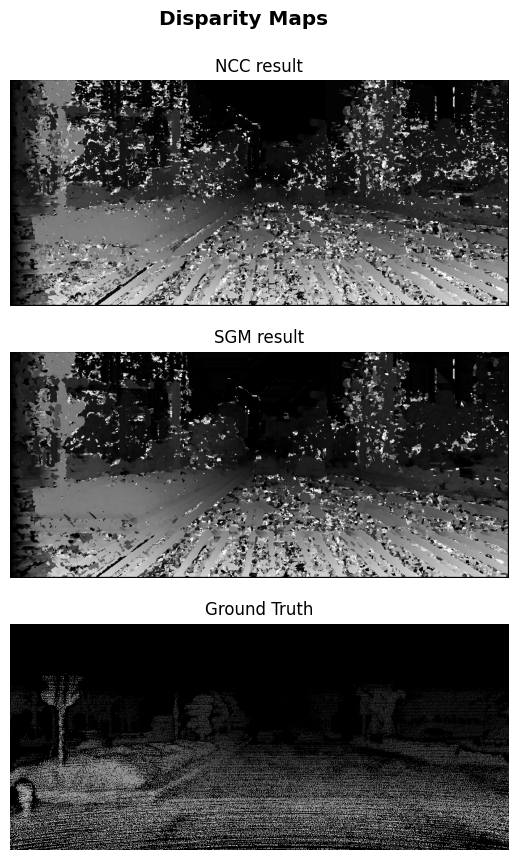

In [10]:
# Showing the result disparity image 
disparity_img_NCC = (disparity_map_NCC_cache/np.max(disparity_map_NCC_cache)) * 255
disparity_img_SGM = (disparity_map_SGM/np.max(disparity_map_SGM)) * 255

f, axis = plt.subplots(3,1, figsize=(13,10))
f.suptitle("Disparity Maps", fontsize="x-large", fontweight="bold", y=0.95)

axis[0].imshow(disparity_img_NCC, cmap='gray')
axis[0].set_title("NCC result")
axis[0].set_axis_off()

axis[1].imshow(disparity_img_SGM, cmap='gray')
axis[1].set_title("SGM result")
axis[1].set_axis_off()

axis[2].imshow(img_tru, cmap='gray')
axis[2].set_title("Ground Truth")
axis[2].set_axis_off()

In [11]:
# Root mean square error analysis

disparity_true = img_tru / 256
H, W = disparity_true.shape

error_map_NCC = np.full(shape=(H,W), fill_value=np.nan)
error_map_SGM = np.full(shape=(H,W), fill_value=np.nan)

count=0
for h in range(H):
    for w in range(W):
        if disparity_true[h,w] != 0:
            error_map_NCC[h,w] = abs(disparity_map_NCC_cache[h,w] - disparity_true[h,w])
            error_map_SGM[h,w] = abs(disparity_map_SGM[h,w] - disparity_true[h,w])
            count += 1

rmse_NCC = np.sqrt(np.nansum(np.square(error_map_NCC)) / count)
rmse_SGM = np.sqrt(np.nansum(np.square(error_map_SGM)) / count)

print(f"NCC Root mean square error: {round(rmse_NCC, 4)}")
print(f"SGM Root mean square error: {round(rmse_SGM, 4)}")

NCC Root mean square error: 16.7927
SGM Root mean square error: 15.2745


In [12]:
# Fraction of pixel errors analysis

error_pixel_NCC_count_4 = np.count_nonzero(error_map_NCC < 4)
error_pixel_NCC_count_2 = np.count_nonzero(error_map_NCC < 2)
error_pixel_NCC_count_1 = np.count_nonzero(error_map_NCC < 1)
error_pixel_NCC_count_05 = np.count_nonzero(error_map_NCC < 0.5)
error_pixel_NCC_count_025 = np.count_nonzero(error_map_NCC < 0.25)

error_pixel_SGM_count_4 = np.count_nonzero(error_map_SGM < 4)
error_pixel_SGM_count_2 = np.count_nonzero(error_map_SGM < 2)
error_pixel_SGM_count_1 = np.count_nonzero(error_map_SGM < 1)
error_pixel_SGM_count_05 = np.count_nonzero(error_map_SGM < 0.5)
error_pixel_NCC_count_025 = np.count_nonzero(error_map_NCC < 0.25)

print(f"Comparing point count: {count}\n")
print(f"===========\n    NCC    \n===========")
print(f"Fraction of pixels error < 4:      {round(error_pixel_NCC_count_4/count, 4)}")
print(f"Fraction of pixels error < 2:      {round(error_pixel_NCC_count_2/count, 4)}")
print(f"Fraction of pixels error < 1:      {round(error_pixel_NCC_count_1/count, 4)}")
print(f"Fraction of pixels error < 0.5:    {round(error_pixel_NCC_count_05/count, 4)}")
print(f"Fraction of pixels error < 0.25:   {round(error_pixel_NCC_count_025/count, 4)}")
print()
print(f"===========\n    SGM    \n===========")
print(f"Fraction of pixels error < 4:      {round(error_pixel_SGM_count_4/count, 4)}")
print(f"Fraction of pixels error < 2:      {round(error_pixel_SGM_count_2/count, 4)}")
print(f"Fraction of pixels error < 1:      {round(error_pixel_SGM_count_1/count, 4)}")
print(f"Fraction of pixels error < 0.5:    {round(error_pixel_SGM_count_05/count, 4)}")
print(f"Fraction of pixels error < 0.25:   {round(error_pixel_NCC_count_025/count, 4)}")

Comparing point count: 90029

    NCC    
Fraction of pixels error < 4:      0.6477
Fraction of pixels error < 2:      0.5564
Fraction of pixels error < 1:      0.4035
Fraction of pixels error < 0.5:    0.2346
Fraction of pixels error < 0.25:   0.1111

    SGM    
Fraction of pixels error < 4:      0.6778
Fraction of pixels error < 2:      0.5429
Fraction of pixels error < 1:      0.3468
Fraction of pixels error < 0.5:    0.1913
Fraction of pixels error < 0.25:   0.1111


In [13]:
# Algorithm Runtime
print(f"Runtime of standard NCC algorithm:  {round(runtime_NCC, 4)} (s)")
print(f"Runtime of cache NCC algorithm   :  {round(runtime_NCC_cache, 4)} (s)")
print(f"Runtime of SGM algorithm         :  {round(runtime_SGM, 4)} (s)")

Runtime of standard NCC algorithm:  498.3046 (s)
Runtime of cache NCC algorithm   :  246.7497 (s)
Runtime of SGM algorithm         :  4.2414 (s)
